# Imports

In [71]:
from data_classes import LAQNData, HealthData
from os import path
import pandas as pd

# Load data

### Load the hourly NO$_2$ data

In [72]:
data_folder = path.join(path.abspath(""), "LAQN_data")
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [73]:
NO2_hourly = LAQNData(url, data_folder, species, start_date, end_date)

In [74]:
hourly_df = NO2_hourly.read_csv(index_col="date")
print(hourly_df.shape)

Reading NO2_hourly_2000-01-01_2021-01-01.csv...
(184105, 192)


In [86]:
hourly_df.tail()

,TD0,BG3,BG1,BG2,BN2,BN3,BN1,BX5,BX2,BQ7,...,WMD,WM0,MY1,WM6,WMZ,WMB,NB1,WM8,WM9,VS1
date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 20:00:00,NaN,NaN,NaN,27.7,NaN,NaN,NaN,NaN,26.6,21.9,...,NaN,26.8,25.8,30.9,NaN,28.6,43.2,NaN,NaN,NaN
2020-12-31 21:00:00,NaN,NaN,NaN,29.4,NaN,NaN,NaN,NaN,25.6,20.7,...,NaN,25.1,27.8,30.1,NaN,28.1,31.0,NaN,NaN,NaN
2020-12-31 22:00:00,NaN,NaN,NaN,21.5,NaN,NaN,NaN,NaN,18.6,15.6,...,NaN,25.1,24.3,34.2,NaN,32.5,37.0,NaN,NaN,NaN
2020-12-31 23:00:00,NaN,NaN,NaN,21.7,NaN,NaN,NaN,NaN,16.6,13.5,...,NaN,26.0,21.5,33.1,NaN,29.4,41.4,NaN,NaN,NaN
2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Load the weekly mortality per capita data

In [87]:
data_folder = path.join(path.abspath(""), "mortality_data")
filename = "weekly_mortality_percapita_London.csv"

In [88]:
mortality_weekly = HealthData(data_folder, filename=filename)

In [89]:
mortality_df = pd.DataFrame(mortality_weekly.read_csv(index_col="date"))
print(mortality_df.shape)

Reading weekly_mortality_percapita_London.csv...
(495, 3)


In [90]:
mortality_df.tail()

,total_population,weekly_deaths,death_fraction
date,,,
2019-05-31,8.957411e+06,809.0,0.000090
2019-06-07,8.958444e+06,919.0,0.000103
2019-06-14,8.959478e+06,900.0,0.000100
2019-06-21,8.960512e+06,900.0,0.000100
2019-06-28,8.961546e+06,892.0,0.000100


# Process data

### Resample the hourly NO$_2$ data using a custom date list

In [115]:
weekly_dates = mortality_df.index

Only retain the NO$_2$ data up to the final mortality datapoint:

In [116]:
hourly_df = hourly_df.loc[hourly_df.index < weekly_dates.max()]

In [117]:
weekly_NO2_df = hourly_df.groupby(weekly_dates[weekly_dates.searchsorted(hourly_df.index)]).mean()

We've now generated a dataframe of weekly mean NO$_2$ concentrations (from the hourly data) using the weekly dates given by the mortality dataset. 
- The `searchsorted()` function takes the `hourly_df` index and inserts it into `weekly_dates` to return an array of indices where the hourly elements should be inserted to maintain order in the weekly dates. See docs [here](https://pandas.pydata.org/pandas-docs/version/0.21.1/generated/pandas.DatetimeIndex.searchsorted.html).
- Placing these indices inside `weekly_dates[]` produces an array the same length as the hourly index, where each entry is the corresponding "weekly" date.
- The `groupby()` operation then performs the `mean()` function on the hourly data, grouping by the assigned weekly dates in the previous step. See docs [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

### Spatially average the NO$_2$ data for all of London

In [118]:
NO2_df = pd.DataFrame(weekly_NO2_df.mean(axis=1), columns=["mean_NO2"]).join(mortality_df)

In [119]:
NO2_df

,mean_NO2,total_population,weekly_deaths,death_fraction
date,,,,
2010-01-08,54.274204,8.004813e+06,1226.0,0.000153
2010-01-15,59.165384,8.007094e+06,1262.0,0.000158
2010-01-22,67.432424,8.009374e+06,1186.0,0.000148
2010-01-29,64.820489,8.011654e+06,1093.0,0.000136
2010-02-05,67.035762,8.013935e+06,1035.0,0.000129
...,...,...,...,...
2019-05-31,28.116937,8.957411e+06,809.0,0.000090
2019-06-07,30.860090,8.958444e+06,919.0,0.000103
2019-06-14,31.332680,8.959478e+06,900.0,0.000100


<AxesSubplot:xlabel='mean_NO2', ylabel='death_fraction'>

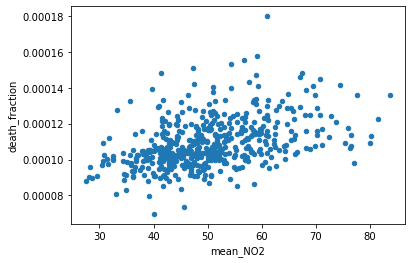

In [120]:
NO2_df.plot.scatter(x="mean_NO2", y="death_fraction")